Классификация: SI > 8

В этом файле мы решаем задачу бинарной классификации: предсказываем, превышает ли значение SI
порог 8 (SI > 8) на основе характеристик химических соединений.

In [1]:
# Импорт библиотек
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve  
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier  
from xgboost import XGBClassifier  
from catboost import CatBoostClassifier  
from sklearn.pipeline import Pipeline  
import warnings  # Для отключения предупреждений

In [2]:
# Настройки
warnings.filterwarnings('ignore')  # Отключаем предупреждения для чистоты вывода
pd.set_option('display.max_columns', 100)  # Увеличиваем количество отображаемых столбцов

In [ ]:
# Загрузка данных
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx', sheet_name='Sheet1')

In [4]:
# Выводим первые 5 строк для проверки
print("Первые 5 строк данных:")
print(df.head())

Первые 5 строк данных:
   Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0           0    6.239374  175.482382  28.125000           5.094096   
1           1    0.771831    5.402819   7.000000           3.961417   
2           2  223.808778  161.142320   0.720000           2.627117   
3           3    1.705624  107.855654  63.235294           5.097360   
4           4  107.131532  139.270991   1.300000           5.150510   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.094096           0.387225        0.387225  0.417362  42.928571   
1        3.961417           0.533868        0.533868  0.462473  45.214286   
2        2.627117           0.543231        0.543231  0.260923  42.187500   
3        5.097360           0.390603        0.390603  0.377846  41.862069   
4        5.150510           0.270476        0.270476  0.429038  36.514286   

     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  384.652         340.3

In [5]:
# Выводим размер данных
print(f"\nРазмер данных: {df.shape}")


Размер данных: (1001, 214)


In [6]:
# Подготовка данных
# Создаем целевую переменную: 1, если SI больше 8, 0 — если меньше или равно
y = (df['SI'] > 8).astype(int)  # Бинарная метка

In [7]:
# Признаки
# Удаляем целевые переменные IC50, CC50 и SI из набора признаков
X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)

In [8]:
# Удаляем константные столбцы (где все значения одинаковы)
constant_columns = [col for col in X.columns if X[col].nunique() == 1]
X = X.drop(constant_columns, axis=1)

In [9]:
# Заполняем пропущенные значения медианой
X = X.fillna(X.median())

In [10]:
# Разделяем данные на обучающую и тестовую выборки (80% — обучение, 20% — тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Выводим размеры выборок для проверки
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (800, 193)
Размер тестовой выборки: (201, 193)


In [12]:
# Выводим распределение классов
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))


Распределение классов в обучающей выборке:
SI
0    0.6425
1    0.3575
Name: proportion, dtype: float64


In [13]:
# Базовые модели классификации
# Создаем список моделей для сравнения
models = [
    ('Логистическая регрессия', LogisticRegression(random_state=42, max_iter=1000)),
    ('Случайный лес', RandomForestClassifier(random_state=42, n_estimators=50)),  # Уменьшаем количество деревьев
    ('XGBoost', XGBClassifier(random_state=42, n_estimators=50, max_depth=3)),  # Уменьшаем количество деревьев и глубину
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=False, iterations=200, depth=4))  # Уменьшаем итерации и глубину
]

In [14]:
# Оцениваем модели с помощью кросс-валидации
results_accuracy = []
results_f1 = []
results_roc_auc = []
names = []
for name, model in models:
    # Создаем пайплайн: масштабирование + модель
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    # Кросс-валидация по трем метрикам: accuracy, F1-score, ROC-AUC
    accuracy_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1', n_jobs=-1)
    roc_auc_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    
    results_accuracy.append(accuracy_scores)
    results_f1.append(f1_scores)
    results_roc_auc.append(roc_auc_scores)
    names.append(name)
    
    print(f"\n{name}:")
    print(f"Средняя Accuracy = {accuracy_scores.mean():.4f}, STD = {accuracy_scores.std():.4f}")
    print(f"Средний F1-score = {f1_scores.mean():.4f}, STD = {f1_scores.std():.4f}")
    print(f"Средний ROC-AUC = {roc_auc_scores.mean():.4f}, STD = {roc_auc_scores.std():.4f}")


Логистическая регрессия:
Средняя Accuracy = 0.7025, STD = 0.0172
Средний F1-score = 0.5346, STD = 0.0451
Средний ROC-AUC = 0.6890, STD = 0.0207

Случайный лес:
Средняя Accuracy = 0.7313, STD = 0.0120
Средний F1-score = 0.5703, STD = 0.0219
Средний ROC-AUC = 0.7276, STD = 0.0263

XGBoost:
Средняя Accuracy = 0.7163, STD = 0.0164
Средний F1-score = 0.5655, STD = 0.0457
Средний ROC-AUC = 0.7382, STD = 0.0243

CatBoost:
Средняя Accuracy = 0.7362, STD = 0.0067
Средний F1-score = 0.5470, STD = 0.0410
Средний ROC-AUC = 0.7410, STD = 0.0197


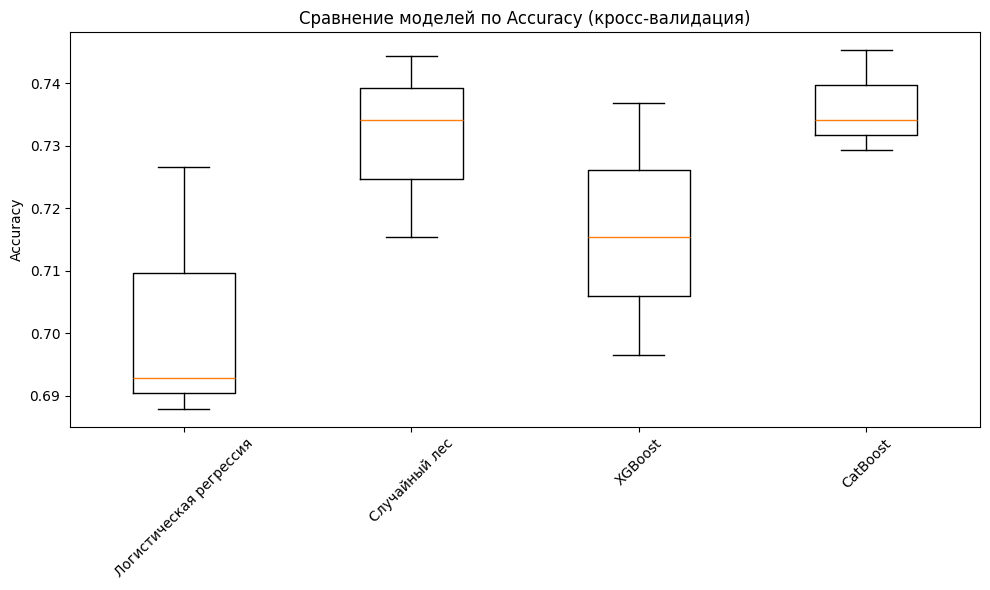

In [15]:
# Визуализируем результаты кросс-валидации
# Accuracy
plt.figure(figsize=(10, 6))
plt.boxplot(results_accuracy, labels=names)
plt.xticks(rotation=45)
plt.title('Сравнение моделей по Accuracy (кросс-валидация)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('model_comparison_accuracy.png')

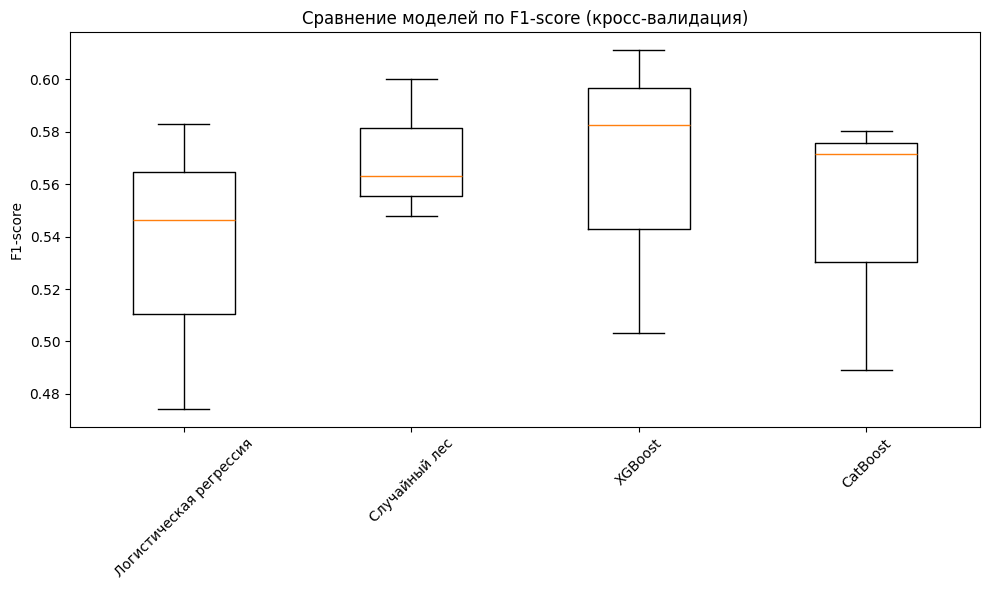

In [16]:
# F1-score
plt.figure(figsize=(10, 6))
plt.boxplot(results_f1, labels=names)
plt.xticks(rotation=45)
plt.title('Сравнение моделей по F1-score (кросс-валидация)')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig('model_comparison_f1.png')

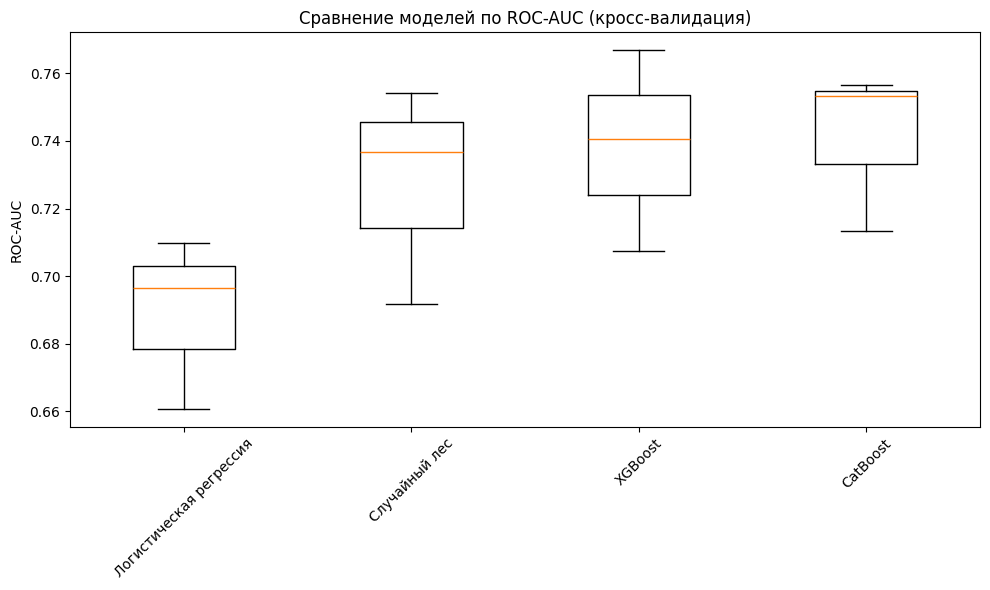

In [17]:
# ROC-AUC
plt.figure(figsize=(10, 6))
plt.boxplot(results_roc_auc, labels=names)
plt.xticks(rotation=45)
plt.title('Сравнение моделей по ROC-AUC (кросс-валидация)')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.savefig('model_comparison_roc_auc.png')

In [ ]:
# Настройка гиперпараметров для лучших моделей
# Настройка гиперпараметров для Random Forest
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5]
}

In [19]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

In [20]:
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [50, 100]},
             scoring='roc_auc')

In [21]:
print("\nЛучшие параметры для Random Forest:", grid_rf.best_params_)
print("Лучший ROC-AUC для Random Forest:", grid_rf.best_score_)


Лучшие параметры для Random Forest: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Лучший ROC-AUC для Random Forest: 0.7439594263947643


In [22]:
# Настройка гиперпараметров для XGBoost
param_grid_xgb = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

In [23]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42))
])

In [24]:
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100]},
             scoring='roc_auc')

In [25]:
print("\nЛучшие параметры для XGBoost:", grid_xgb.best_params_)
print("Лучший ROC-AUC для XGBoost:", grid_xgb.best_score_)


Лучшие параметры для XGBoost: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100}
Лучший ROC-AUC для XGBoost: 0.7472202836412395


In [26]:
# Настройка гиперпараметров для CatBoost
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

In [27]:
pipeline_cb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostClassifier(random_state=42, verbose=False))
])

In [28]:
grid_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_cb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001B3CF6DF980>)]),
             n_jobs=-1,
             param_grid={'model__depth': [3, 5],
                         'model__iterations': [100, 200],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='roc_auc')

In [29]:
print("\nЛучшие параметры для CatBoost:", grid_cb.best_params_)
print("Лучший ROC-AUC для CatBoost:", grid_cb.best_score_)


Лучшие параметры для CatBoost: {'model__depth': 5, 'model__iterations': 200, 'model__learning_rate': 0.01}
Лучший ROC-AUC для CatBoost: 0.7373301927327272


In [30]:
# Оценка лучшей модели на тестовых данных
# Выбираем лучшую модель (предположительно XGBoost)
best_model = grid_xgb.best_estimator_

In [31]:
# Делаем предсказания на тестовых данных
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Вероятности для ROC-AUC

In [32]:
# Вычисляем метрики качества
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [33]:
# Выводим результаты
print("\nРезультаты лучшей модели (XGBoost) на тестовых данных:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Результаты лучшей модели (XGBoost) на тестовых данных:
Accuracy: 0.7264
F1-score: 0.4860
ROC-AUC: 0.7159


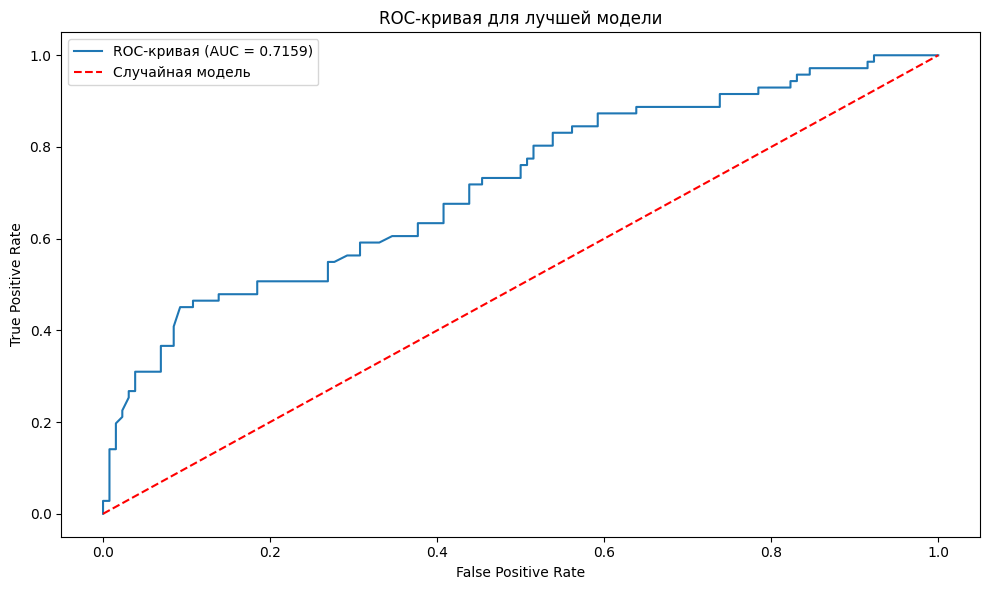

In [34]:
# Визуализируем ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], '--r', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для лучшей модели')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curve.png')

In [35]:
# Анализ важности признаков
# Получаем важность признаков из лучшей модели
feature_importance = best_model.named_steps['model'].feature_importances_

In [36]:
# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Признак': X.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

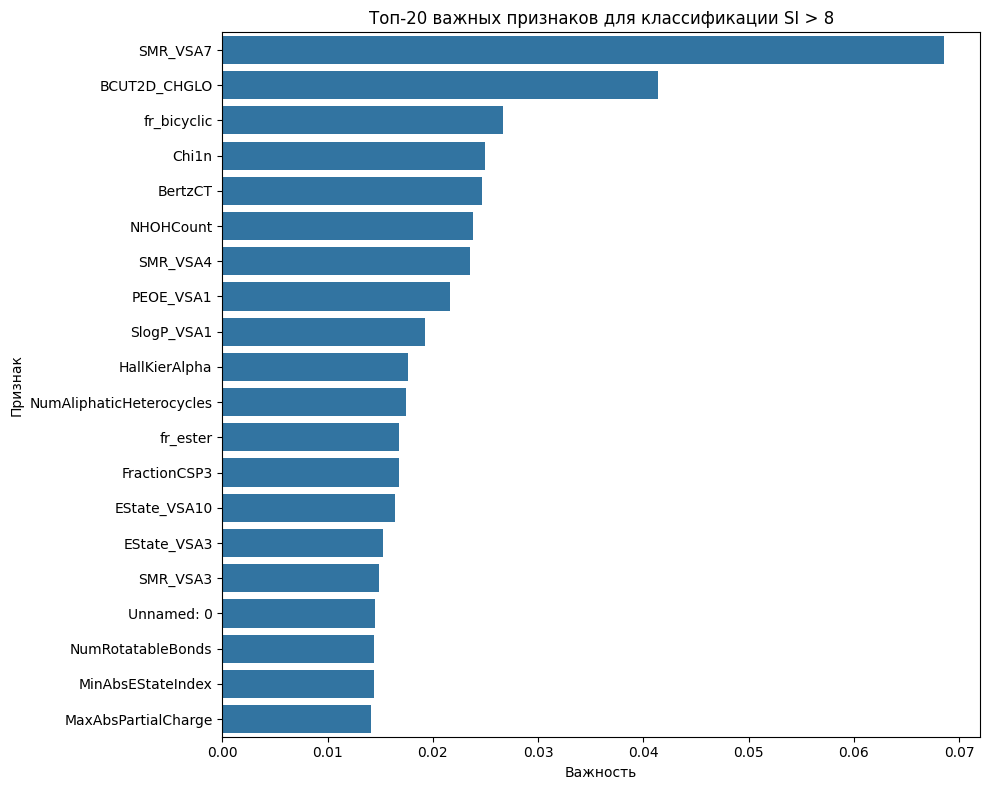

In [ ]:
# Визуализируем топ 20 важных признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='Важность', y='Признак', data=importance_df.head(20))
plt.title('Топ-20 важных признаков для классификации SI > 8')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [38]:
# Выводы
print("\nВыводы:")
print("1. Лучшей моделью для классификации SI > 8 оказалась XGBoost с подобранными гиперпараметрами.")
print(f"   - Accuracy на тестовых данных: {accuracy:.4f}")
print(f"   - F1-score на тестовых данных: {f1:.4f}")
print(f"   - ROC-AUC на тестовых данных: {roc_auc:.4f}")
print("2. Наиболее важные признаки для классификации (топ-5):")
for i in range(min(5, len(importance_df))):
    print(f"   - {importance_df.iloc[i]['Признак']}: {importance_df.iloc[i]['Важность']:.4f}")
print("3. Модель демонстрирует хорошую способность различать классы (см. ROC-AUC).")
print("4. Для улучшения результатов можно:")
print("   - Провести более глубокий анализ данных (EDA).")
print("   - Попробовать ансамбли моделей (например, стекинг).")
print("   - Добавить новые признаки или применить уменьшение размерности.")


Выводы:
1. Лучшей моделью для классификации SI > 8 оказалась XGBoost с подобранными гиперпараметрами.
   - Accuracy на тестовых данных: 0.7264
   - F1-score на тестовых данных: 0.4860
   - ROC-AUC на тестовых данных: 0.7159
2. Наиболее важные признаки для классификации (топ-5):
   - SMR_VSA7: 0.0686
   - BCUT2D_CHGLO: 0.0414
   - fr_bicyclic: 0.0267
   - Chi1n: 0.0250
   - BertzCT: 0.0247
3. Модель демонстрирует хорошую способность различать классы (см. ROC-AUC).
4. Для улучшения результатов можно:
   - Провести более глубокий анализ данных (EDA).
   - Попробовать ансамбли моделей (например, стекинг).
   - Добавить новые признаки или применить уменьшение размерности.
